In [2]:
import polars as pl
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("Clustered.txt", skiprows=1,
                         names=["Transition Energy (eV)", "Transition Amplitude (a.u.)", "Transition Width (eV)",
                                "TDM_x", "TDM_y", "TDM_z", "TDM Theta (degrees)", "Transition Symmetry",
                                "TDM_xx", "TDM_yy", "TDM_zz", "TDM_xy", "TDM_xz", "TDM_yz", "Originating atom",
                                "Originating MO", "Cluster"])

df = pl.from_dataframe(df)
print(df)
print(len(df))

shape: (13, 17)
┌────────────┬────────────┬────────────┬───────────┬───┬────────┬────────────┬───────────┬─────────┐
│ Transition ┆ Transition ┆ Transition ┆ TDM_x     ┆ … ┆ TDM_yz ┆ Originatin ┆ Originati ┆ Cluster │
│ Energy     ┆ Amplitude  ┆ Width (eV) ┆ ---       ┆   ┆ ---    ┆ g atom     ┆ ng MO     ┆ ---     │
│ (eV)       ┆ (a.u.)     ┆ ---        ┆ f64       ┆   ┆ i64    ┆ ---        ┆ ---       ┆ f64     │
│ ---        ┆ ---        ┆ f64        ┆           ┆   ┆        ┆ i64        ┆ i64       ┆         │
│ f64        ┆ f64        ┆            ┆           ┆   ┆        ┆            ┆           ┆         │
╞════════════╪════════════╪════════════╪═══════════╪═══╪════════╪════════════╪═══════════╪═════════╡
│ 283.80191  ┆ 0.017448   ┆ 0.236435   ┆ 0.039977  ┆ … ┆ 0      ┆ 1          ┆ 117       ┆ null    │
│ 284.68234  ┆ 0.048513   ┆ 0.223871   ┆ 0.022457  ┆ … ┆ 0      ┆ 2          ┆ 119       ┆ null    │
│ 285.20261  ┆ 0.014443   ┆ 0.225601   ┆ 0.030391  ┆ … ┆ 0      ┆ 1        

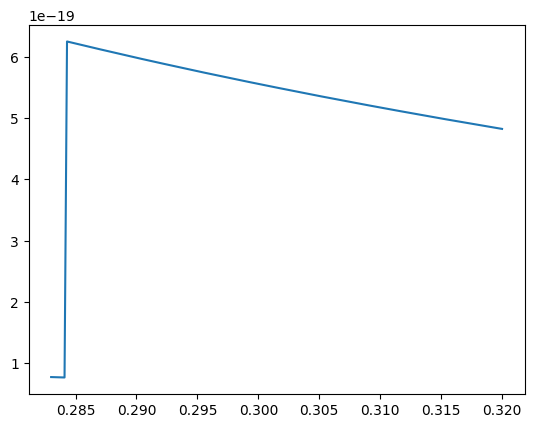

In [28]:
import periodictable as pt
import periodictable.xsf as xsf


def sim_ma(tensor, position, width, theta, phi):
    en = np.linspace(283, 320, 10000)
    e = np.array(
        [np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]
    )

    # Use einsum to calculate the matrix element
    ma = e.T @ tensor @ e

    peak = 1 / width * np.exp(-(((en - position) / width) ** 2))
    return peak * ma, en


def sim_ma_cluster(df, cluster, theta=0, phi=0):
    # Extract the tensor and convert into a diagonal matrix
    tensor = np.diag(df[cluster, ["TDM_xx", "TDM_yy", "TDM_zz"]].to_numpy()[0])
    position = df[cluster, "Transition Energy (eV)"]
    width = df[cluster, "Transition Width (eV)"]
    theta = np.radians(theta)

    ma, en = sim_ma(tensor, position, width, theta, phi)
    return ma, en


def sim_bare_atom(molecule):
    en = np.linspace(283, 320, 10000)
    # convert to keV
    en *= 1e-3
    lam = 1.23984e-4 / en

    # Paserse the molecule into a list of elements
    molecule = pt.formula(molecule)
    atoms = molecule.atoms
    f1 = 0
    f2 = 0
    w = molecule.mass

    for atom in atoms.keys():
        xray = xsf.Xray(atom)
        _f1, _f2 = xray.scattering_factors(energy = en)
        f1 += atoms[atom] * _f1
        f2 += atoms[atom] * _f2

    # Mass absorption is only really f2
    mu = 2* pt.constants.electron_radius*lam*f2/w
    return mu, en

def sim_step(molecule):
    mu, en = sim_bare_atom(molecule)



mu, en = sim_bare_atom("C32H16N8Zn1")
import matplotlib.pyplot as plt
plt.plot(en, mu)

In [31]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

def combine_ma(df, theta = 0, phi = 0):
    ma = []
    mu, en = sim_bare_atom("C32H16N8Zn1")
    ma.append(mu)
    for cluser in range(len(df)):
        ma_, en = sim_ma_cluster(df, cluser, theta, phi)
        ma.append(ma_)
    return np.array(ma), en

@widgets.interact(theta = (0, 90, 1), phi = (0, 360, 1))
def plot_ma(theta = 0, phi = 0):
    ma, en = combine_ma(df, theta, phi)
    plt.plot(en, np.sum(ma, axis=0))

interactive(children=(IntSlider(value=0, description='theta', max=90), IntSlider(value=0, description='phi', m…